# An intro to quantum machine learning 🚀
(with multiple qubits)

In [8]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from utils import plot_decision_boundary

from qiskit_machine_learning.algorithms import VQC
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap, ZFeatureMap

We pick a synthetic dataset and train a quantum circuit to classify it.

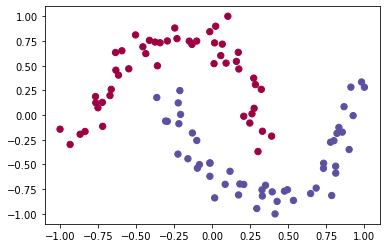

In [2]:
n_samples = 100

X, y = make_moons(n_samples=n_samples, noise=0.1)
scaler = MinMaxScaler((-1, 1))
X = scaler.fit_transform(X)

# plot the dataset 
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)


In [3]:
# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Variational Quantum Classifier

In [11]:
num_qubits = 2
feature_map = ZFeatureMap(feature_dimension=2, reps=1)
print(feature_map.decompose())

     ┌───┐┌─────────────┐
q_0: ┤ H ├┤ P(2.0*x[0]) ├
     ├───┤├─────────────┤
q_1: ┤ H ├┤ P(2.0*x[1]) ├
     └───┘└─────────────┘


In [28]:
var_form = TwoLocal(num_qubits, ['rz', 'ry'], 'cz', reps=3, insert_barriers=True)
print(var_form.decompose())

     ┌──────────┐┌──────────┐ ░     ░ ┌──────────┐┌──────────┐ ░     ░ »
q_0: ┤ Rz(θ[0]) ├┤ Ry(θ[2]) ├─░──■──░─┤ Rz(θ[4]) ├┤ Ry(θ[6]) ├─░──■──░─»
     ├──────────┤├──────────┤ ░  │  ░ ├──────────┤├──────────┤ ░  │  ░ »
q_1: ┤ Rz(θ[1]) ├┤ Ry(θ[3]) ├─░──■──░─┤ Rz(θ[5]) ├┤ Ry(θ[7]) ├─░──■──░─»
     └──────────┘└──────────┘ ░     ░ └──────────┘└──────────┘ ░     ░ »
«     ┌──────────┐┌───────────┐ ░     ░ ┌───────────┐┌───────────┐
«q_0: ┤ Rz(θ[8]) ├┤ Ry(θ[10]) ├─░──■──░─┤ Rz(θ[12]) ├┤ Ry(θ[14]) ├
«     ├──────────┤├───────────┤ ░  │  ░ ├───────────┤├───────────┤
«q_1: ┤ Rz(θ[9]) ├┤ Ry(θ[11]) ├─░──■──░─┤ Rz(θ[13]) ├┤ Ry(θ[15]) ├
«     └──────────┘└───────────┘ ░     ░ └───────────┘└───────────┘


In [29]:
optimizer = SPSA(maxiter=40)
vqc = VQC(num_qubits, 
        feature_map, 
        ansatz = var_form, 
        loss = 'cross_entropy',
        optimizer = optimizer, 
)

In [37]:
print(vqc.circuit.decompose())

     ┌───┐┌─────────────┐┌──────────┐┌──────────┐ ░     ░ ┌──────────┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├┤ Rz(θ[0]) ├┤ Ry(θ[2]) ├─░──■──░─┤ Rz(θ[4]) ├»
     ├───┤├─────────────┤├──────────┤├──────────┤ ░  │  ░ ├──────────┤»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ Rz(θ[1]) ├┤ Ry(θ[3]) ├─░──■──░─┤ Rz(θ[5]) ├»
     └───┘└─────────────┘└──────────┘└──────────┘ ░     ░ └──────────┘»
«     ┌──────────┐ ░     ░ ┌──────────┐┌───────────┐ ░     ░ ┌───────────┐»
«q_0: ┤ Ry(θ[6]) ├─░──■──░─┤ Rz(θ[8]) ├┤ Ry(θ[10]) ├─░──■──░─┤ Rz(θ[12]) ├»
«     ├──────────┤ ░  │  ░ ├──────────┤├───────────┤ ░  │  ░ ├───────────┤»
«q_1: ┤ Ry(θ[7]) ├─░──■──░─┤ Rz(θ[9]) ├┤ Ry(θ[11]) ├─░──■──░─┤ Rz(θ[13]) ├»
«     └──────────┘ ░     ░ └──────────┘└───────────┘ ░     ░ └───────────┘»
«     ┌───────────┐
«q_0: ┤ Ry(θ[14]) ├
«     ├───────────┤
«q_1: ┤ Ry(θ[15]) ├
«     └───────────┘


In [30]:
vqc.fit(X_train, y_train)

In [31]:
test_accuracy = vqc.score(X_test, y_test)
print(f'Testing success ratio: {test_accuracy}')

Testing success ratio: 0.8666666666666667


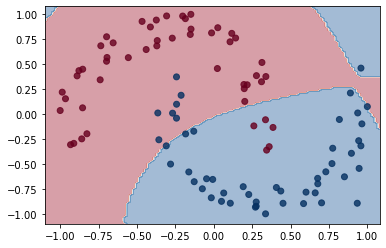

In [32]:
plot_decision_boundary(vqc, X, y, pad=0.1)

## Quantum Support Vector Machine

In [9]:
from qiskit_machine_learning.algorithms import QSVC

In [10]:
from qiskit_machine_learning.kernels import FidelityQuantumKernel

In [11]:
# Initialize the quantum kernel
kernel = FidelityQuantumKernel(feature_map=ZFeatureMap(feature_dimension=2, reps=2))


In [13]:
qsvc = QSVC(quantum_kernel=kernel)

In [14]:
# fit the model
qsvc.fit(X_train, y_train)

QSVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
     decision_function_shape='ovr', degree=3, gamma='scale', max_iter=-1,
     probability=False,
     quantum_kernel=<qiskit_machine_learning.kernels.fidelity_quantum_kernel.FidelityQuantumKernel object at 0x292f29600>,
     random_state=None, shrinking=True, tol=0.001, verbose=False)

In [15]:
test_accuracy = qsvc.score(X_test, y_test)
print(f'Testing success ratio: {test_accuracy}')

Testing success ratio: 0.8333333333333334


# Your turn:

Classify the Iris dataset using the QML algorithm of your choice.

In [16]:
# Your code here